In [1]:
import os
import tensorflow as tf
import cv2 as cv
import glob
import h5py
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten, Dense, Dropout, Add, Activation
from math import ceil
from random import shuffle
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
def create_dataset():
    dataset_path = glob.glob('./Dataset/training/image_2/*.png')
    ground_truth = glob.glob('./Dataset/training/gt_image_2/*.png')
    #print(dataset_path)
    #print(ground_truth)
    #labels = [0 if 'textbox' in addr else 1 for addr in dataset_path]
    #images = cv.imread(dataset_path)
    
    compressed=list(zip(dataset_path, ground_truth))
    #shuffle(compressed)
    addrs, labels = zip(*compressed)
    
    train_addrs = addrs[0:int(0.6*len(addrs))]
    train_labels = labels[0:int(0.6*len(labels))]
    test_addrs = addrs[int(0.8*len(addrs)):]
    test_labels = labels[int(0.8*len(labels)):]
    
    train_x_l = len(train_addrs)
    train_y_l = len(train_labels)
    test_x_l = len(test_addrs)
    test_y_l = len(test_labels)
    
    train_shape = (train_x_l,  256, 256, 3)
    train_output_shape = (train_y_l, 256, 256, 3)
    test_shape = (test_x_l,  256, 256, 3) #375,1242
    test_output_shape = (test_y_l, 256, 256, 3)
    
    # Abrir un archivo HDF5 en modo escritura y crear los datasets
    hdf5_file = h5py.File('./Dataset/pictures_dataset.h5', mode='w')
    hdf5_file.create_dataset("train_img", train_shape, np.int8)
    hdf5_file.create_dataset("test_img", test_shape, np.int8)
    hdf5_file.create_dataset("train_mean", train_shape[1:], np.float32)

    hdf5_file.create_dataset("train_labels", train_output_shape, np.int8)        
    hdf5_file.create_dataset("test_labels", test_output_shape, np.int8)
    
    #LoadImages
    #hdf5_file["train_labels"][...] = train_labels
    #hdf5_file["test_labels"][...] = test_labels

    train_shape=hdf5_file["train_img"].shape
    mean = np.zeros(train_shape[1:], np.float32)
    
    #Training addresses
    for i in range(len(train_addrs)):
        addr = train_addrs[i]
        img = cv.imread(addr)
        img = cv.resize(img, (256, 256), interpolation=cv.INTER_NEAREST)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        hdf5_file["train_img"][i, ...] = img[None]
        #mean += img / float(len(train_labels))
    
    #Training output addresses
    for i in range(len(train_labels)):
        addr = train_labels[i]
        img = cv.imread(addr)
        img = cv.resize(img, (256, 256), interpolation=cv.INTER_NEAREST)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        hdf5_file["train_labels"][i, ...] = img[None]
        #mean += img / float(len(train_labels))
    
    #Testing addresses
    for i in range(len(test_addrs)):
        addr = test_addrs[i]
        img = cv.imread(addr)
        img = cv.resize(img, (256, 256), interpolation=cv.INTER_NEAREST)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        hdf5_file["test_img"][i, ...] = img[None]
    
    #Testing output addresses
    for i in range(len(test_labels)):
        addr = test_labels[i]
        img = cv.imread(addr)
        img = cv.resize(img, (256, 256), interpolation=cv.INTER_NEAREST)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        hdf5_file["test_labels"][i, ...] = img[None]
        #mean += img / float(len(train_labels))
    
    #hdf5_file["train_mean"][...] = mean
    hdf5_file.close()
    
create_dataset()

In [2]:
def extract_dataset():
    batch_size = 30
    batch_n = 10
    # Abrir el archivo HDF5, modo lectura
    hdf5_file = h5py.File('./Dataset/pictures_dataset.h5', "r")
    
    # Determinar la longitud del dataset de entrenamiento
    data_num = hdf5_file["train_img"].shape[0]
    test_num = hdf5_file["test_img"].shape[0]
    
    # Crear una lista de lotes para barajear los datos
    batches_list = list(range(int(ceil(float(data_num) / batch_size))))
    shuffle(batches_list)
    
    training_list = list(range(int(ceil(float(test_num) / batch_size))))

    # Recorramos los lotes
    for n, i in enumerate(batches_list):
        i_s = i * batch_size  # Indice de la primer imagen en este lote
        i_e = min([(i + 1) * batch_size, data_num])  # Indice de la última imagen en este lote

        # Leer las imágenes del lote
        training_images = hdf5_file["train_img"][i_s:i_e]
        
        # Leer etiquetas
        training_labels = hdf5_file["train_labels"][i_s:i_e]
        
        #print (n+1, '/', len(batches_list))
        #print (f"Etiqueta: {training_labels[0]}")
        '''
        plt.imshow(training_images[0])
        plt.show()
        plt.imshow(training_labels[0])
        plt.show()
        '''
        if n == (batch_n-1):  # finalizar despues de batch_num-1 lotes
            break
    for n, i in enumerate(training_list):
        i_s = i * batch_size  # Indice de la primer imagen en este lote
        i_e = min([(i + 1) * batch_size, test_num])  # Indice de la última imagen en este lote

        # Leer las imágenes del lote
        test_images = hdf5_file["test_img"][i_s:i_e]
        
        # Leer etiquetas
        test_labels = hdf5_file["test_labels"][i_s:i_e]
        
        #print (n+1, '/', len(batches_list))
        #print (f"Etiqueta: {test_labels[0]}")
    
        #plt.imshow(test_images[0])
        #plt.show()   
        if n == (batch_n-1):  # finalizar despues de batch_num-1 lotes
            break
    hdf5_file.close()
    return (training_images, training_labels), (test_images, test_labels)

var = extract_dataset()

In [3]:
def load_dataset_from_route():
    #(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
    (train_images, train_labels),(test_images, test_labels) = extract_dataset()
    training_set = (train_images, train_labels)
    test_set = (test_images, test_labels)
    return training_set, test_set

training_set, test_set = load_dataset_from_route()
#class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']
training_images = training_set[0]/255
training_labels = training_set[1]
test_images = test_set[0]/255
test_labels = test_set[1]



enconder graph
(None, 2, 2, 4)
score_2
(None, 6, 6, 4)
pool_4
(None, 16, 16, 512)
score_pool_4
(None, 16, 16, 4)
score_pool_4
(None, 6, 6, 4)


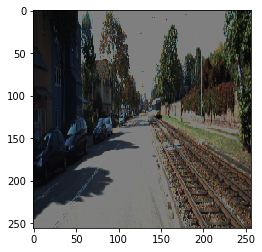

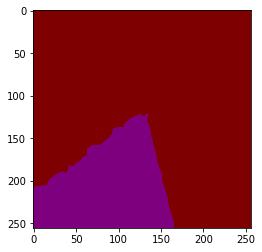

ValueError: A target array with shape (30, 256, 256, 3) was passed for an output of shape (None, 256, 256, 4) while using as loss `categorical_crossentropy`. This loss expects targets to have the same shape as the output.

In [9]:
def create_model(classes):
    #model = vgg16.VGG16(include_top=True, weights=None, input_tensor=None, input_shape=(32,32,3), pooling='max', classes=10)
    #sequential doesn't seem to work that well because 
    input_shape = (256,256,3)
    #fcn_model = Sequential()
    img_input = layers.Input(shape=input_shape)
    
    #primer bloque Conv -> Conv -> Pooling
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    
    #segundo bloque
    x = layers.Conv2D(128, (3, 3),activation='relu',padding='same',name='block2_conv1')(x)
    x = layers.Conv2D(128, (3, 3),activation='relu',padding='same',name='block2_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    
    #tercer bloque
    x = layers.Conv2D(256, (3, 3),activation='relu',padding='same',name='block3_conv1')(x)
    x = layers.Conv2D(256, (3, 3),activation='relu',padding='same',name='block3_conv2')(x)
    x = layers.Conv2D(256, (3, 3),activation='relu',padding='same',name='block3_conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    
    pool_3 = x
    
    #cuarto bloque
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
    
    pool_4 = x
    
    #5to bloque
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    
    #Fullyconnected Layer
    #x = layers.Flatten(name='flatten')(x)
    #x = layers.Dense(4096, activation='relu', name='fc1')(x)
    #x = layers.Dense(4096, activation='relu', name='fc2')(x)
    #x = layers.Dense(classes, activation='softmax', name='predictions')(x)
    
    #fc_6
    x = layers.Conv2D(4096, 7, padding='valid', activation='relu', use_bias=True, name='fc_1')(x)
    x = layers.Dropout(0.5)(x)
    
    #fc_7
    x = Conv2D(4096, 1, padding='valid', activation='relu', use_bias=True, name='fc_2')(x)
    x = Dropout(0.5)(x)

    encoder_graph = Conv2D(classes, 1, padding='valid', activation='relu', use_bias=True, name='encoder_graph')(x)
    print("enconder graph")
    print(encoder_graph.shape)

    # Unpool to 16x
    score_2 = layers.Conv2DTranspose(classes, 4, strides=(2, 2), padding='valid')(encoder_graph)
    print("score_2")
    print(score_2.shape)
    score_pool_4 = layers.Conv2D(classes, 1, padding='valid', use_bias=True)(pool_4)
    print("pool_4")
    print(pool_4.shape)
    print("score_pool_4")
    print(score_pool_4.shape)
    score_pool_4 = layers.Cropping2D(cropping=5)(score_pool_4)
    print("score_pool_4")
    print(score_pool_4.shape)
    score_16x_upsampled = Add()([score_2, score_pool_4])
        
    # Unpool to 8x
    score_4 = layers.Conv2DTranspose(classes, 4, strides=(2, 2), padding='valid')(score_16x_upsampled)
    score_pool_3 = layers.Conv2D(classes, 1, padding='valid', use_bias=True)(pool_3)
    #score_4 = layers.ZeroPadding2D(padding=((1,0), (1, 0)))(score_4)
    #print(score_4.shape)
    score_pool_3 = layers.Cropping2D(cropping=9)(score_pool_3)
    #print(score_pool_3.shape)
    score_8x_upsampled = Add()([score_4, score_pool_3])

    # Unpool to image shape
    upsample = layers.Conv2DTranspose(classes, 16, strides=(23, 23), padding='same')(score_8x_upsampled)        
    upsample = layers.Cropping2D(cropping=33)(upsample)
    #upsample = layers.Conv2DTranspose(classes, 64, strides=(16,16), padding='same')(upsample)
    
    output_graph = Activation('softmax')(upsample)

    #print(output_graph.shape)
    #print(img_input.shape)
    
    #return output_graph
    
    fcn_model = Model(img_input, output_graph)
    return fcn_model

vgg_model = create_model(3)
vgg_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc', 'mse'])
plt.imshow(training_images[0])
plt.show()

plt.imshow(training_labels[0])
plt.show()
#vgg_model.summary()
vgg_model.fit(x=training_images, y=training_labels,batch_size = 32, epochs = 50, verbose = 1,callbacks = None, validation_split=0.0, validation_data=(test_images,test_labels) )
#ValueError: A target array with shape (30, 256, 256, 3) was passed for an output of shape (None, 56, 56, 2) 
#while using as loss `mean_squared_error`. This loss expects targets to have the same shape as the output.
#Esto se refiere a que output_graph es un arreglo con dimensiones (None, 56, 56,2)
vgg_model.save('modelo_completo_sgd_4clases.h5')
vgg_model.save_weights('pesos_modelo_sgd_4clases.h5')

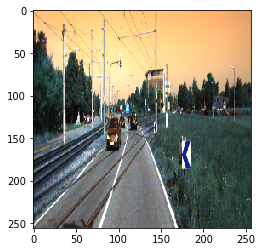

(1, 256, 256, 3)
(1, 256, 256, 3)


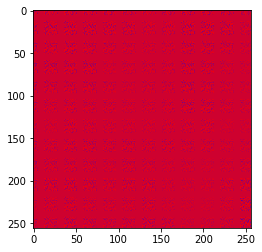

In [8]:
image = cv.imread('./Dataset/testing/image_2/um_000003.PNG')
image = cv.resize(image, (256,256))
plt.imshow(image)
plt.show()
image = np.resize(image, (1,256,256,3))
#plt.imshow(image)
image = tf.cast(image, tf.float32)
print(image.shape)
vgg_model = load_model('./modelo_completo_sgd.h5')
prediction = vgg_model.predict(image, batch_size = None, verbose = 0, steps = None, callbacks = None, max_queue_size = 10, workers = 1, use_multiprocessing = False)
#print(prediction)
print(prediction.shape)
plt.imshow(prediction[0])
plt.show()
#predicted = np.argmax(prediction.shape[0], axis=1)
#print(class_names[predicted])